# **1) Setup**

## Nvidia GPU


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Install Everything

In [ ]:
!pip install git+https://github.com/ultralytics/ultralytics
!pip install roboflow
!pip install shapely
!pip install chess

  Cloning https://github.com/ultralytics/ultralytics to /tmp/pip-req-build-6dyyhk_r
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/ultralytics /tmp/pip-req-build-6dyyhk_r
  Resolved https://github.com/ultralytics/ultralytics to commit 7f37790134527e328c475ac292efdc39b1cd7b5e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ultralytics: filename=ultralytics-8.3.49-py3-none-any.whl size=898708 sha256=806c0736a15c7674a0665a17059981eb3587454c0ce55841dfa5915e56ff3fe1
  Stored in directory: /tmp/pip-ephem-wheel-cache-0yhceu8x/wheels/78/1b/12/0119ff1988b138a6281c3df369726a8e79431f03b5b5635a58
Successfully built ultralytics
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
   

## Import Everything

In [ ]:
import torch
from ultralytics import YOLO
from roboflow import Roboflow
import cv2
from google.colab.patches import cv2_imshow  # Import cv2_imshow for displaying images in Colab
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as image
import pandas as pd
from numpy import asarray
from PIL import Image
from shapely.geometry import Polygon
import chess
import chess.pgn
from IPython.display import display, SVG

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Test Image

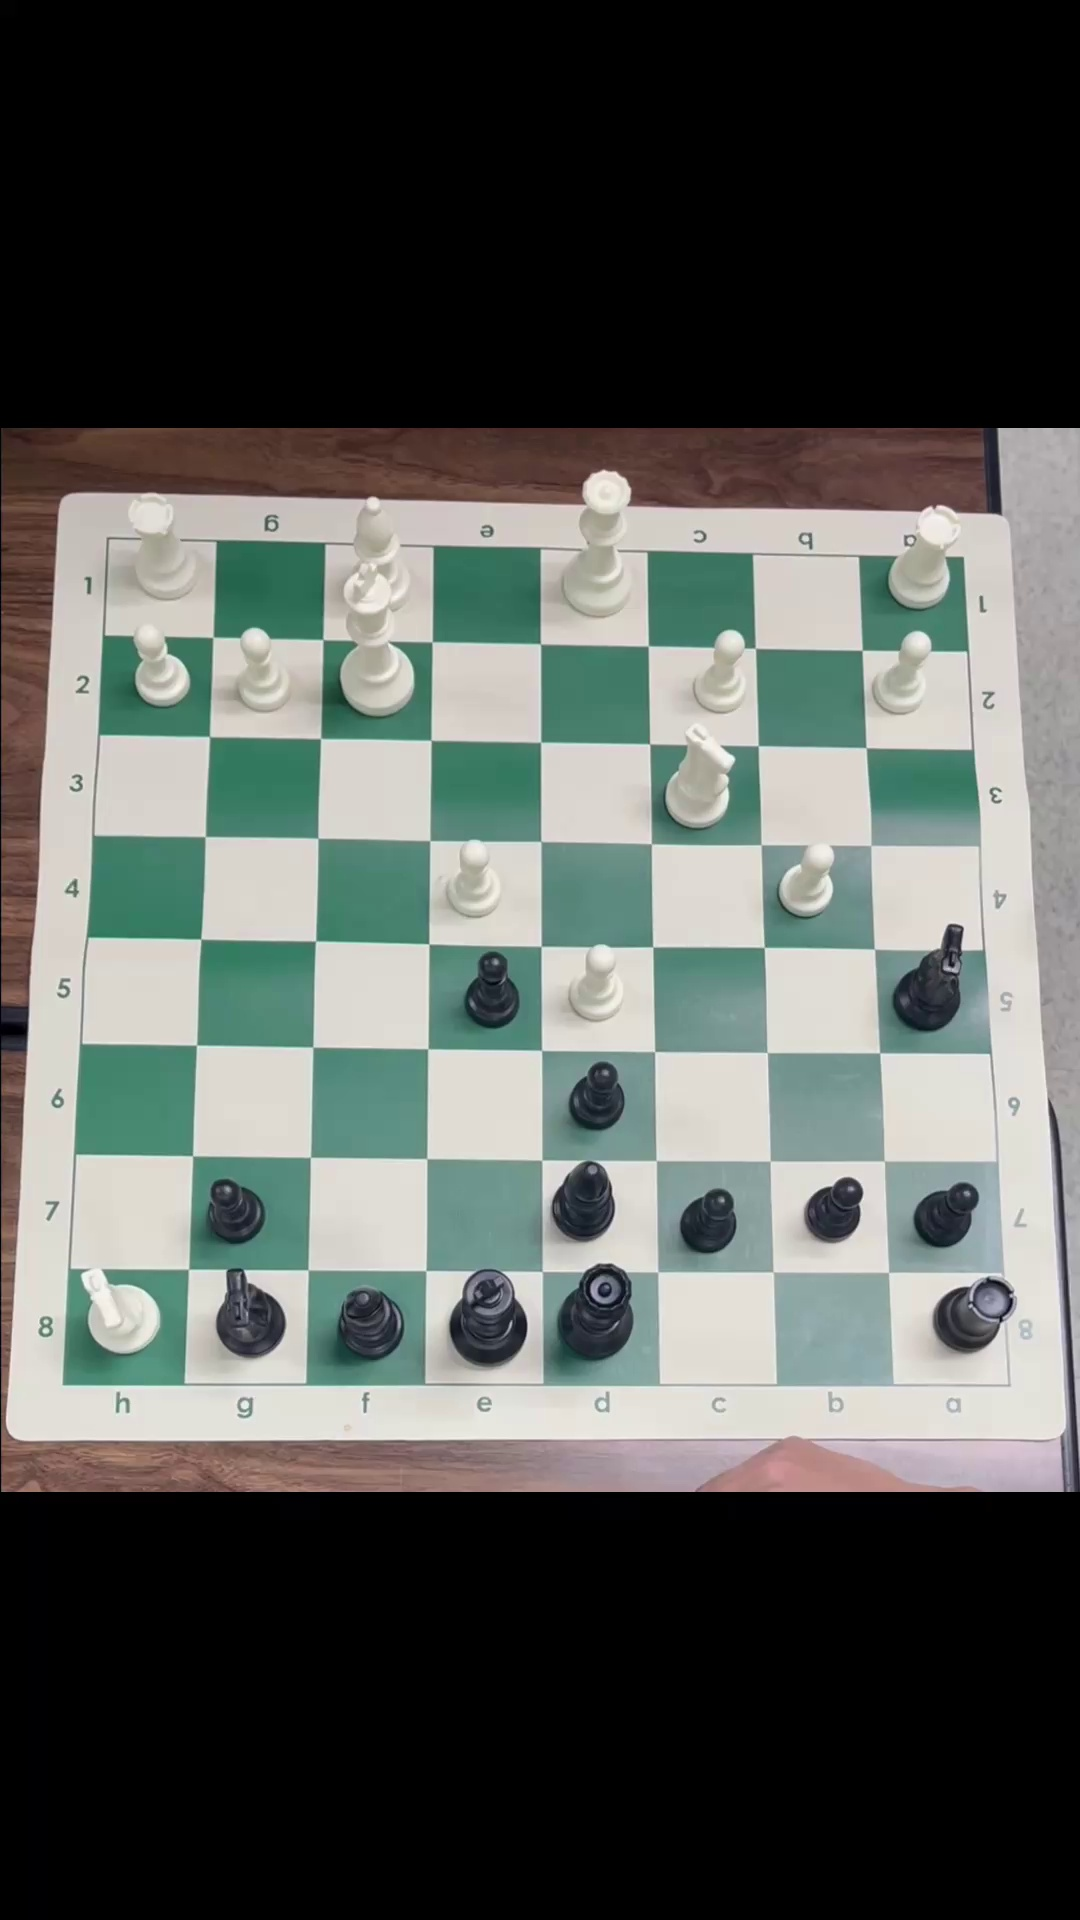

In [ ]:
test_image_path = "/content/drive/MyDrive/cu-chess-detection/test_img/2_move_student.jpg"
test_img = cv2.imread(test_image_path)

cv2_imshow(test_img)

# **2) Import Data**

## Import Data from Roboflow

In [ ]:
!curl -L "https://app.roboflow.com/ds/nEyHEfFojt?key=hhHesZjbrG" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
!curl -L "https://app.roboflow.com/ds/KgPrU8DXzm?key=oyPZaj1ced" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

Streaming output truncated to the last 5000 lines.
 extracting: train/images/055b79dd8db4c43e1a23be6095aaf624_jpg.rf.18a50d2c6495ce4677b4883c93c5c821.jpg  
 extracting: train/images/055b79dd8db4c43e1a23be6095aaf624_jpg.rf.575b93f9e65caca7a2fdcc2b6e48db2a.jpg  
 extracting: train/images/055b79dd8db4c43e1a23be6095aaf624_jpg.rf.76d67e17392603e90cf9bac6895ec8fe.jpg  
 extracting: train/images/05de676d5078dc0a13796f3f627993ef_jpg.rf.118b366e54c500c39e0609dd277b37fc.jpg  
 extracting: train/images/05de676d5078dc0a13796f3f627993ef_jpg.rf.235bf186b321a734b51b02cda077ecec.jpg  
 extracting: train/images/05de676d5078dc0a13796f3f627993ef_jpg.rf.40405be88e59f2b68ad034e323ab23d4.jpg  
 extracting: train/images/05de676d5078dc0a13796f3f627993ef_jpg.rf.47e8061ab7334f57c016c83edbcc428f.jpg  
 extracting: train/images/05de676d5078dc0a13796f3f627993ef_jpg.rf.6cc58ddaa339ee67c7301a29a5c54a0f.jpg  
 extracting: train/images/05de676d5078dc0a13796f3f627993ef_jpg.rf.71347a5a6b477f88c81110fc3f9f5871.jpg  
 ext

# **3) Chess Piece Detection Model Train(Run once)**



*   Train Chess Piece Detection Model
*   If already train -> Get model at section 5)

In [ ]:
model = YOLO('yolo8n.pt')

# Train the model
model.train(data='/content/drive/MyDrive/chess-dataset/data.yaml',
            epochs=100,
            imgsz=416,
            batch=32,
            device=0,
            save_dir="runs/custom_train")

# **4) Chess Board Detection Model Train(Run once)**

*   Train Chess Board Corner Detection Model
*   If already train -> Get model at section 5)

In [ ]:
model = YOLO('yolo8n.pt')

# Train the model
model.train(data='/content/drive/MyDrive/chess-dataset/data.yaml',  # Path to data.yaml
            epochs=100,           # Number of training epochs
            imgsz=416,           # Input image size
            batch=32,            # Batch size
            device=0,
            save_dir="runs/custom_train")

# **5) Getting pre-train data from drive**

## Getting Chess piece, Chess board Detection Model from drive

In [ ]:
piece_model_path = "/content/drive/MyDrive/cu-chess-detection/models/best.pt"
corner_model_path = "/content/drive/MyDrive/cu-chess-detection/models/corner-detect.pt"

piece_model = YOLO(piece_model_path)
corner_model = YOLO(corner_model_path)

## Check that Model import completely

In [ ]:
# piece_model_test = piece_model(test_img)
# corner_model_test = corner_model(test_img)

# cv2_imshow(piece_model_test[0].plot())
# cv2_imshow(corner_model_test[0].plot())

#**6) Function Define**

## 6.1) Get Chess Board corner

In [ ]:
def get_chessboard_corners(results):
  '''
  return as 4*2 array of [x,y] of chessboard_corners:
  #0 = top-left
  #1 = top-right
  #2 = bottom-right
  #3 = bottom-left
  If corner did not detect, return [0,0] on that corner
  '''
  detections = results[0]
  boxes = detections.boxes.xyxy.cpu().numpy() if hasattr(detections.boxes.xyxy, 'cpu') else detections.boxes.xyxy
  scores = detections.boxes.conf.cpu().numpy() if hasattr(detections.boxes.conf, 'cpu') else detections.boxes.conf
  class_ids = detections.boxes.cls.cpu().numpy() if hasattr(detections.boxes.cls, 'cpu') else detections.boxes.cls

  corner_dict = {0: None, 1: None, 2: None, 3: None}

  for box, score, class_id in zip(boxes, scores, class_ids):
      if class_id in corner_dict:
          if corner_dict[class_id] is None or score > corner_dict[class_id][1]:
              x_center = (box[0] + box[2]) / 2
              y_center = (box[1] + box[3]) / 2
              corner_dict[class_id] = ((x_center, y_center), score)

  corners = []
  for class_id in [2, 3, 1, 0]:  # Order: top-left, top-right, bottom-right, bottom-left
      if corner_dict[class_id]:
          corners.append(corner_dict[class_id][0])
      else:
          corners.append((0, 0)) # Corner Not found

  return np.array(corners)

In [ ]:
# # TEST
# corners = get_chessboard_corners(corner_model_test)
# image_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# plt.figure(figsize=(15, 15))
# plt.imshow(image_rgb)
# plt.scatter(corners[:, 0], corners[:, 1], c='red', s=50)
# plt.axis('off')
# plt.show()

## 6.0) Model Utilities

In [ ]:
def get_corner(img, corner_model_path):

    corner_model = YOLO(corner_model_path)
    corner_points = corner_model.predict(source=img, conf=0.01, save=False, verbose=False)

    return get_chessboard_corners(corner_points)

def find_pieces(img, piece_model_path):

    piece_model = YOLO(piece_model_path)
    results = piece_model.predict(source=img, conf=0.1, save=False, verbose=False)

    return results

## 6.2) Get Chess Board with padding

In [ ]:
def get_chessboard_corners_with_paddings(corners, padding_ratio=0.065):
    """
    Expand the detected chessboard corners by adding padding around them,
    taking rotation into account.

    Parameters:
        corners (np.array): An array of shape (4, 2) representing the four corners
                            of the chessboard in the order [top-left, top-right, bottom-right, bottom-left].
        padding_ratio (float): The ratio of the padding relative to the width and height of the board.

    Returns:
        np.array: An array of shape (4, 2) representing the expanded corners.
    """
    # Ensure corners are in NumPy format
    corners = np.array(corners)

    # Compute the center of the board
    center = np.mean(corners, axis=0)

    # Calculate the width and height direction vectors
    top_to_bottom = (corners[3] - corners[0] + corners[2] - corners[1]) / 2  # Average vertical vector
    left_to_right = (corners[1] - corners[0] + corners[2] - corners[3]) / 2  # Average horizontal vector

    # Compute the width and height of the board
    board_width = np.linalg.norm(left_to_right)
    board_height = np.linalg.norm(top_to_bottom)

    # Normalize the direction vectors
    top_to_bottom_unit = top_to_bottom / np.linalg.norm(top_to_bottom)
    left_to_right_unit = left_to_right / np.linalg.norm(left_to_right)

    # Calculate the padding values
    x_padding = padding_ratio * board_width
    y_padding = padding_ratio * board_height

    # Calculate expanded corners
    expanded_corners = np.zeros_like(corners)
    for i, corner in enumerate(corners):
        direction = (corner - center)  # Vector from the center to the corner
        unit_vector = direction / np.linalg.norm(direction)
        expanded_corners[i] = corner + unit_vector * (x_padding + y_padding)  # Expand outward

    return expanded_corners

In [ ]:
# # Test
# corners_with_padding = get_chessboard_corners_with_paddings(corners)
# image_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
# plt.figure(figsize=(15, 15))
# plt.imshow(image_rgb)
# plt.scatter(corners_with_padding[:, 0], corners_with_padding[:, 1], c='red', s=50)
# plt.axis('off')
# plt.show()

## 6.3) Perspective transform

In [ ]:
def four_point_transform(image, rect):

    image = np.asarray(image)
    (tl, tr, br, bl) = rect

    if (tl[0]==0 and tl[1]==0) or (tr[0]==0 and tr[1]==0) or (br[0]==0 and br[1]==0) or (bl[0]==0 and bl[1]==0):
        return image, None  # Return the numpy array directly

    # Compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # Compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # Destination points for perspective transform
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # Compute the perspective transform matrix and apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped, M  # Return the numpy array directly

In [ ]:
# # Test
# corners = corners.astype("float32")
# corners_with_padding = corners_with_padding.astype("float32")

# # Call the function
# transformed_image_nopad, M = four_point_transform(test_img, corners)
# transformed_image, M = four_point_transform(test_img, corners_with_padding)

# # Display the transformed image
# plt.figure(figsize=(10, 10))
# #plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
# plt.imshow(transformed_image_nopad)
# plt.axis('off')
# plt.show()

# plt.figure(figsize=(10, 10))
# plt.imshow(transformed_image)
# plt.axis('off')
# plt.show()

## 6.4) Find and transform Board (6.1-6.3)

In [ ]:
def find_and_transform_board(img, corner_model_path):

    corner_model = YOLO(corner_model_path)
    corner_points = corner_model.predict(source=img, conf=0.2, save=False, verbose=False)
    corners = get_chessboard_corners(corner_points).astype("float32")
    corners_w_pd = get_chessboard_corners_with_paddings(corners,0.065).astype("float32")
    transformed_image_w_padding, _ = four_point_transform(img, corners_w_pd)

    return transformed_image_w_padding

In [ ]:
# #Test
# process_img = find_and_transform_board(test_img, corner_model_path)
# corner_after_perspective_transform = get_corner(process_img, corner_model_path)
# # print(corner_after_perspective_transform)
# image_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
# plt.figure(figsize=(15, 15))
# plt.imshow(process_img)
# plt.scatter(corner_after_perspective_transform[:, 0], corner_after_perspective_transform[:, 1], c='red', s=50)
# plt.axis('off')
# plt.show()

## 6.5) To Fen Function Utils

In [ ]:
def get_square_centers(transformed_image, corner2):
    height = abs(corner2[2][1] - corner2[0][1])
    width = abs(corner2[3][0] - corner2[1][0])

    ranks = range(1, 9)
    files = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    square_centers = {}
    for rank in ranks:
        for file_index, file in enumerate(files):
            x_center = file_index * width // 8 + width // 16 + corner2[0][0]
            y_center = (8 - rank) * height // 8 + height // 16 + corner2[0][1]
            square_centers[(rank, file)] = (x_center, y_center)
    return square_centers

In [ ]:
def to_fen_notation(results, transformed_image, corner2):
    files = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

    class_to_fen = {
        0: 'b',  # Black bishop
        1: 'k',  # Black king
        2: 'n',  # Black knight
        3: 'p',  # Black pawn
        4: 'q',  # Black queen
        5: 'r',  # Black rook
        6: 'B',  # White bishop
        7: 'K',  # White king
        8: 'N',  # White knight
        9: 'P', # White pawn
        10: 'Q', # White queen
        11: 'R'  # White rook
    }

    fen_board = [['' for _ in range(8)] for _ in range(8)]
    square_centers = get_square_centers(transformed_image, corner2)

    # Mapping of squares to their most confident piece prediction
    square_to_piece = {}

    ############
    piece_x = []
    piece_y = []
    piece_labels = []
    ############

    for result in results[0].boxes:
        box = result.xyxy[0]  # Bounding box (x1, y1, x2, y2)
        cls = int(result.cls[0])
        conf = float(result.conf[0])

        # Compute center of the bounding box
        x1, y1, x2, y2 = box.tolist()
        cx, cy = int((x1 + x2) / 2), int((y1 + y2) / 2)
        cy = int(cy - 0.1 * (y2 - y1))  # 10% of the height of the bounding box

        # Find the nearest square
        closest_square = None
        min_distance = float('inf')
        for (rank, file), (sx, sy) in square_centers.items():
            distance = np.sqrt((cx - sx)**2 + (cy - sy)**2)
            if distance < min_distance:
                min_distance = distance
                closest_square = (rank, file)

        # Update square mapping with highest-confidence piece
        if closest_square:
            if closest_square not in square_to_piece or conf > square_to_piece[closest_square]['conf']:
                square_to_piece[closest_square] = {'piece': class_to_fen.get(cls, '?'), 'conf': conf}

    # Assign the most confident pieces to the FEN board
    for (rank, file), piece_data in square_to_piece.items():
        file_index = files.index(file)
        fen_board[8 - rank][file_index] = piece_data['piece']
        ##################
        sx, sy = square_centers[(rank, file)]
        piece_x.append(sx)
        piece_y.append(sy)
        piece_labels.append(piece_data['piece'])
        ####################

    fen_rows = []
    for row in fen_board:
        fen_row = ''
        empty_count = 0
        for square in row:
            if square == '':
                empty_count += 1
            else:
                if empty_count > 0:
                    fen_row += str(empty_count)
                    empty_count = 0
                fen_row += square
        if empty_count > 0:
            fen_row += str(empty_count)
        fen_rows.append(fen_row)

    # Combine rows into the FEN string
    fen_string = '/'.join(fen_rows)

    ###########
    # Visualize everything
    plt.figure(figsize=(15, 15))
    plt.imshow(transformed_image)

    # Plot square centers
    x_centers = [coord[0] for coord in square_centers.values()]
    y_centers = [coord[1] for coord in square_centers.values()]
    plt.scatter(x_centers, y_centers, c='blue', s=30, label='Square Centers')

    # Plot detected chess pieces
    plt.scatter(piece_x, piece_y, c='green', s=50, label='Chess Pieces')
    for i, label in enumerate(piece_labels):
        plt.text(piece_x[i], piece_y[i], label, color='white', fontsize=12, ha='center', va='center',
                 bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))

    # Plot the corners
    plt.scatter(corner_after_perspective_transform[:, 0], corner_after_perspective_transform[:, 1],
                c='red', s=50, label='Corners')

    plt.axis('off')
    plt.legend()
    plt.show()
    ###########
    return fen_string


In [ ]:
def get_fen(img, corner_model_path, piece_model_path):

    process_img = find_and_transform_board(img, corner_model_path)
    corner_after_perspective_transform = get_corner(process_img, corner_model_path)
    #print(corner_after_perspective_transform)
    '''
    #################check
    image = img
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")

    # Convert the image from BGR to RGB (for correct color display with matplotlib)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 15))
    plt.imshow(process_img)
    plt.scatter(corner_after_perspective_transform[:, 0], corner_after_perspective_transform[:, 1], c='red', s=50)
    plt.axis('off')
    plt.show()
    ##################
    '''
    process_img_with_pieces = find_pieces(process_img, piece_model_path)
    fen = to_fen_notation(process_img_with_pieces, process_img, corner_after_perspective_transform)

    return fen

In [ ]:
# # Test
# process_img = find_and_transform_board(test_img, corner_model_path)
# corner_after_perspective_transform = get_corner(process_img, corner_model_path)
# fen = get_fen(test_img, corner_model_path, piece_model_path)
# board = chess.Board(fen=fen)
# plt.figure(figsize=(15, 15))
# plt.imshow(process_img)
# plt.scatter(corner_after_perspective_transform[:, 0], corner_after_perspective_transform[:, 1], c='red', s=50)
# plt.axis('off')
# plt.show()
# print(board)
# print(fen)

NameError: name 'test_img' is not defined

# **7) Test with video**

In [ ]:
import chess

def get_move_between_fens(initial_fen, final_fen):

    white_board = chess.Board(initial_fen + " w - - 0 1")
    black_board = chess.Board(initial_fen + " b - - 0 1")
    final_board = chess.Board(final_fen)

    for potential_move in white_board.legal_moves:
        test_board = white_board.copy()
        test_board.push(potential_move)

        if test_board.fen().split()[0] == final_board.fen().split()[0]:
            return True,white_board.san(potential_move)

    for potential_move in black_board.legal_moves:
        test_board = black_board.copy()
        test_board.push(potential_move)

        if test_board.fen().split()[0] == final_board.fen().split()[0]:
            return False,black_board.san(potential_move)

    return "",""

def fen_to_pgn(fen_list):

    result = ""
    is_White_Start,tmp_str = get_move_between_fens(fen_list[0],fen_list[1])
    if is_White_Start=="":return "1. d4"
    if is_White_Start:
      for i in range(1,len(fen_list)):
        if i%2 == 1:
          result += str((i+1)//2) + "."
        result+=get_move_between_fens(fen_list[i-1],fen_list[i])[1]+" "

    else:
      for i in range(1,len(fen_list)):
        if i == 1:
          result += "1... "
        if i%2 == 0:
          result += str((i)//2+1) + "."
        result+=get_move_between_fens(fen_list[i-1],fen_list[i])[1]+" "

    return result


In [ ]:
import time
from collections import Counter
import cv2
import chess
import chess.svg
from IPython.display import display, SVG
def video_to_fenList(video_path):
  cap = cv2.VideoCapture(video_path)
  frame_count = 0

  last_fen = ""
  fen_list = []

  def count_pieces(fen):
    # Count the number of pieces in the FEN string (ignoring empty squares and slashes)
    return sum(1 for char in fen if char.isalpha())

  while True:
      ret, frame = cap.read()
      if not ret:
          break  # End of video

      # Process every frame
      # Get FEN from the frame (assumes your model paths are provided)

      if frame_count % 300 == 0:

        fen = get_fen(frame, corner_model_path, piece_model_path)

        if fen == last_fen or (count_pieces(fen)>count_pieces(last_fen) and last_fen != ""):
              frame_count += 1
              continue

        if count_pieces(last_fen) - count_pieces(fen) > 1:
            frame_count += 1
            fen = last_fen
            continue

        l = count_pieces(last_fen)
        c = count_pieces(fen)

        last_fen = fen

        # Create a chess board from the most frequent FEN
        board = chess.Board(fen=fen)

        fen_list.append(fen)

        # Display the chess board
        # print(fen)
        # print(c,l)
        display(SVG(chess.svg.board(board=board, size=400)))
        # cv2_imshow(frame)

      # Optionally, clear fen_list if you want to keep it from growing indefinitely
      frame_count += 1


  cap.release()  # Release the video capture object
  return fen_list

NameError: name 'corner_after_perspective_transform' is not defined

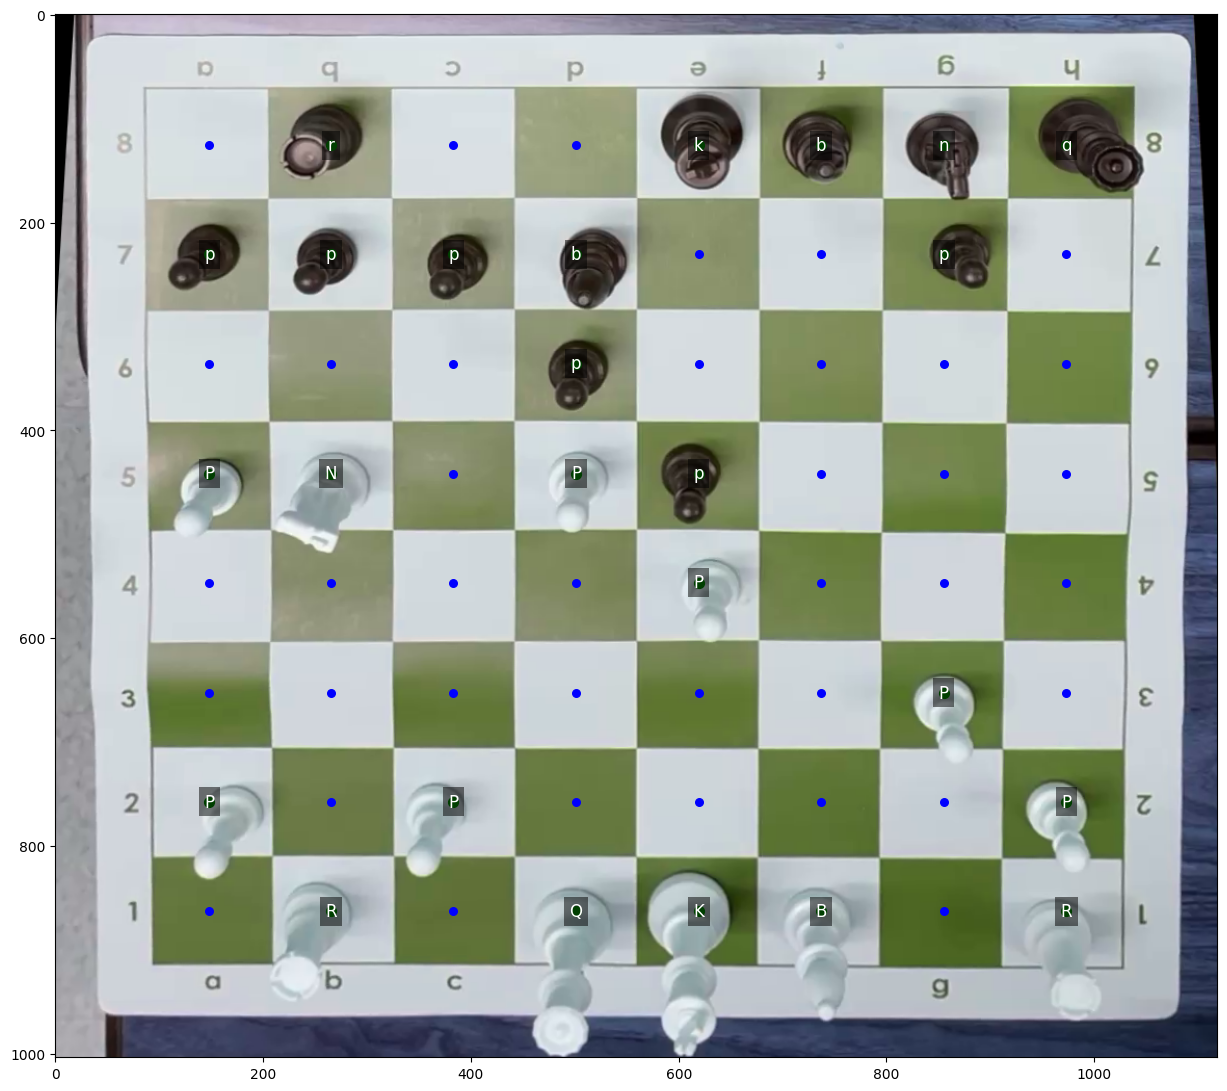

In [ ]:
fenList = video_to_fenList("/content/drive/MyDrive/cu-chess-detection/test_videos/6_Move_student.mp4")

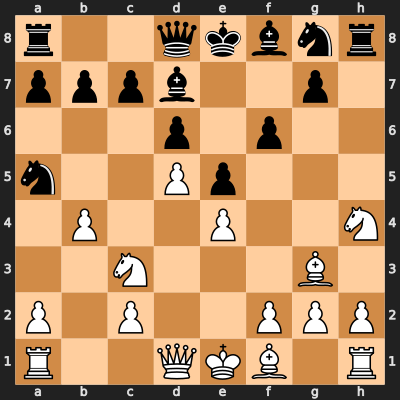

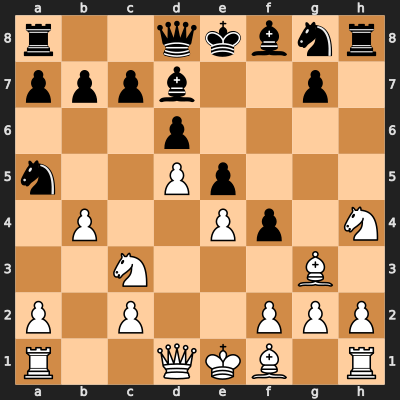

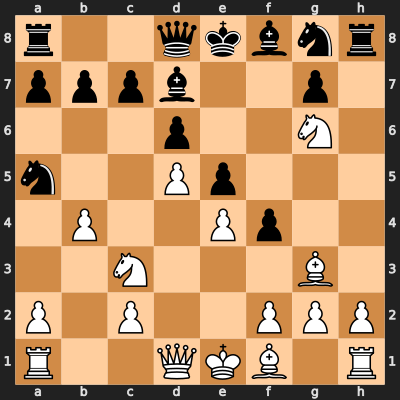

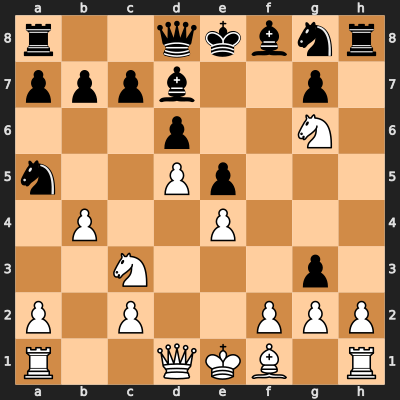

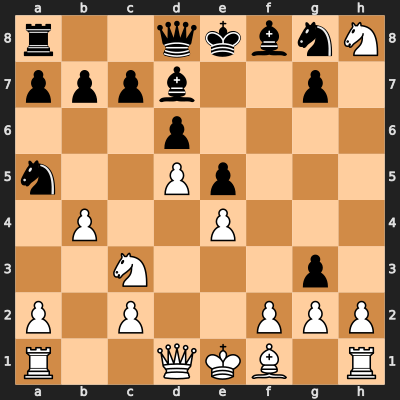

In [ ]:
for fen in fenList:
  board = chess.Board(fen=fen)
  display(SVG(chess.svg.board(board=board, size=400)))

In [ ]:
print(fenList)

['r2qkbnr/pppb2p1/3p1p2/n2Pp3/1P2P2N/2N3B1/P1P2PPP/R2QKB1R', 'r2qkbnr/pppb2p1/3p4/n2Pp3/1P2Pp1N/2N3B1/P1P2PPP/R2QKB1R', 'r2qkbnr/pppb2p1/3p2N1/n2Pp3/1P2Pp2/2N3B1/P1P2PPP/R2QKB1R', 'r2qkbnr/pppb2p1/3p2N1/n2Pp3/1P2P3/2N3p1/P1P2PPP/R2QKB1R', 'r2qkbnN/pppb2p1/3p4/n2Pp3/1P2P3/2N3p1/P1P2PPP/R2QKB1R']


In [ ]:
print(fen_to_pgn(fenList))

1... Qh4+ 2.g3 


In [ ]:
fenList = ['r2qkbnr/pppb2p1/3p1p2/n2Pp3/1P2P2N/2N3B1/P1P2PPP/R2QKB1R', 'r2qkbnr/pppb2p1/3p4/n2Pp3/1P2Pp1N/2N3B1/P1P2PPP/R2QKB1R', 'r2qkbnr/pppb2p1/3p2N1/n2Pp3/1P2Pp2/2N3B1/P1P2PPP/R2QKB1R', 'r2qkbnr/pppb2p1/3p2N1/n2Pp3/1P2P3/2N3p1/P1P2PPP/R2QKB1R', 'r2qkbnN/pppb2p1/3p4/n2Pp3/1P2P3/2N3p1/P1P2PPP/R2QKB1R']


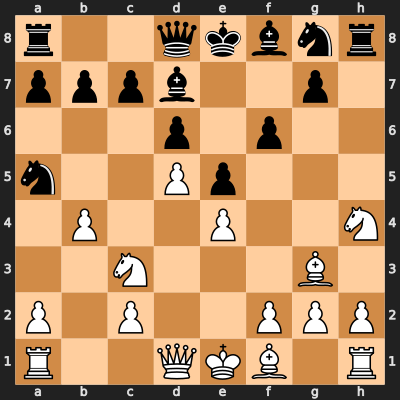

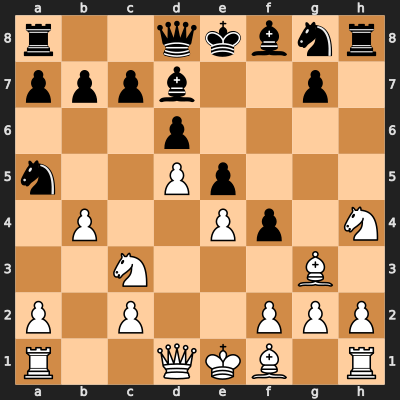

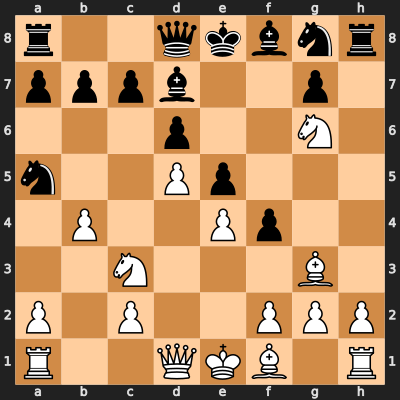

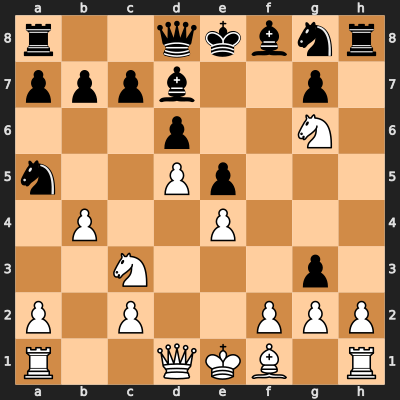

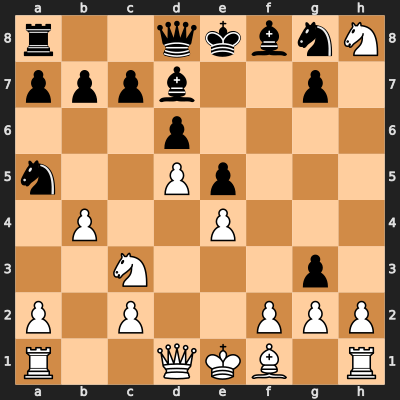

In [ ]:
for fen in fenList:
  board = chess.Board(fen=fen)
  display(SVG(chess.svg.board(board=board, size=400)))


In [ ]:
def fen_to_2d_array(fen):
    """
    Converts a FEN string to a 2D array representing the chessboard.

    Args:
        fen (str): The FEN string for a chessboard position.

    Returns:
        list[list[str]]: A 2D array where each element is a piece symbol or an empty string.
    """
    board = [['' for _ in range(8)] for _ in range(8)]
    chess_board = chess.Board(fen)
    for i in range(8):
        for j in range(8):
            piece = chess_board.piece_at(chess.square(j, 7 - i))
            board[i][j] = piece.symbol() if piece else ''
    return board

def display_board(board):
    """Prints the 2D board array in a readable format."""
    for row in board:
        print(' '.join([square if square != '' else '.' for square in row]))

In [ ]:
def find_move(board_before, board_after):
    moves = []

    board_notation = [
    ["a8", "b8", "c8", "d8", "e8", "f8", "g8", "h8"],
    ["a7", "b7", "c7", "d7", "e7", "f7", "g7", "h7"],
    ["a6", "b6", "c6", "d6", "e6", "f6", "g6", "h6"],
    ["a5", "b5", "c5", "d5", "e5", "f5", "g5", "h5"],
    ["a4", "b4", "c4", "d4", "e4", "f4", "g4", "h4"],
    ["a3", "b3", "c3", "d3", "e3", "f3", "g3", "h3"],
    ["a2", "b2", "c2", "d2", "e2", "f2", "g2", "h2"],
    ["a1", "b1", "c1", "d1", "e1", "f1", "g1", "h1"],
    ]


    # Iterate through each cell in the 8x8 chessboard
    for row in range(8):
        for col in range(8):
            piece_before = board_before[row][col]
            piece_after = board_after[row][col]

            # If there is a change at this position
            if piece_before != piece_after:

                # Case 1: A piece was moved from this position
                if piece_before != '.' and piece_after == '.':
                    move_from = board_notation[row][col]
                    for target_row in range(8):
                        for target_col in range(8):
                            p_after = board_after[target_row][target_col]
                            if (piece_before == p_after and
                                board_before[target_row][target_col] == '.'):
                                moves.append(move_from + board_notation[target_row][target_col])

                # Case 2: A piece was moved to this position
                if piece_after != '.' and piece_before == '.':
                    move_to = board_notation[row][col]
                    for target_row in range(8):
                        for target_col in range(8):
                            p_before = board_before[target_row][target_col]
                            if (piece_after == p_before and
                                board_after[target_row][target_col] == '.'):
                                moves.append(board_notation[target_row][target_col] + move_to)

    return moves


In [ ]:
def get_turn_start(board_before, move):
    turn_start = ''
    lower_alphabet = 'prbqk'  # Black pieces
    upper_alphabet = 'PRBQK'  # White pieces

    # Extract the starting position from the move
    start = move[:2]
    start_row, start_col = get_index(start, board_notation)
    piece = board_before[start_row][start_col]

    # Determine the turn's starting player based on the piece's case
    if piece in lower_alphabet:
        turn_start = 'b'  # Black
    elif piece in upper_alphabet:
        turn_start = 'w'  # White

    return turn_start

# Example usage
turn_start = get_turn_start(board_before, list_of_moves[0])
print(turn_start)

def uci_to_san(board_before, move):
    # Extract start and end positions from the move
    start = move[:2]
    end = move[2:]

    # Get piece and indices for start and end positions
    start_row, start_col = get_index(start, board_notation)
    piece = board_before[start_row][start_col]
    end_row, end_col = get_index(end, board_notation)
    captured_piece = board_before[end_row][end_col]

    # Handle captures
    if captured_piece != '.':
        if piece.lower() == 'p':  # Pawn
            san = start[0] + 'x' + end
        else:  # Other pieces
            san = piece.upper() + 'x' + end
    else:
        if piece.lower() == 'p':  # Pawn
            san = end
        else:  # Other pieces
            san = piece.upper() + end

    return san


In [ ]:
display_board(fen_to_2d_array(fenList[0]))

r . . q k b n r
p p p b . . p .
. . . p . p . .
n . . P p . . .
. P . . P . . N
. . N . . . B .
P . P . . P P P
R . . Q K B . R


# **Video to csv**

In [ ]:
def video_to_pgn(vdo_path):
    fen_list = video_to_fenList(vdo_path)
    pgn = fen_to_pgn(fen_list)
    return pgn

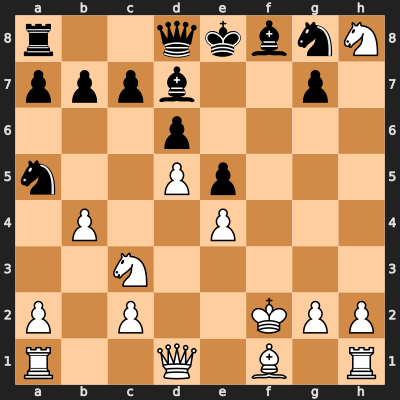

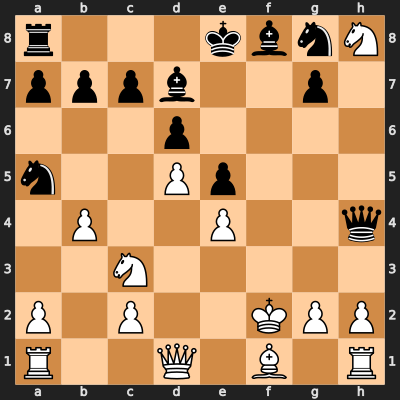

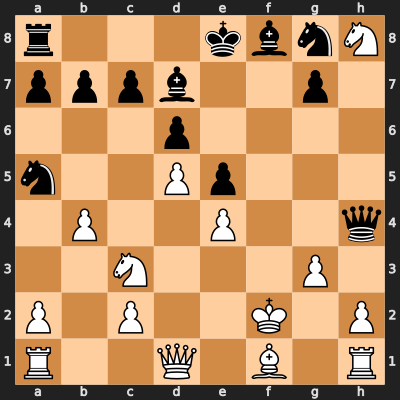

1... Qh4+ 2.g3 


In [ ]:
print(video_to_pgn("/content/drive/MyDrive/cu-chess-detection/test_videos/2_Move_rotate_student.mp4"))

In [ ]:
import os

def video_to_csv(video_dir):
    data = []
    for video_name in os.listdir(video_dir):

        if video_name.endswith(".mp4"):
            video_path = os.path.join(video_dir, video_name)
            pgn = video_to_pgn(video_path)
            data.append({"row_id": video_name, "output": pgn})

    df = pd.DataFrame(data)
    return df

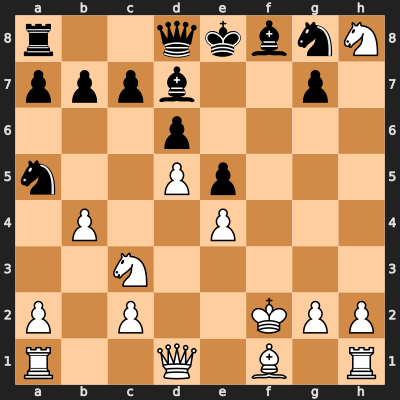

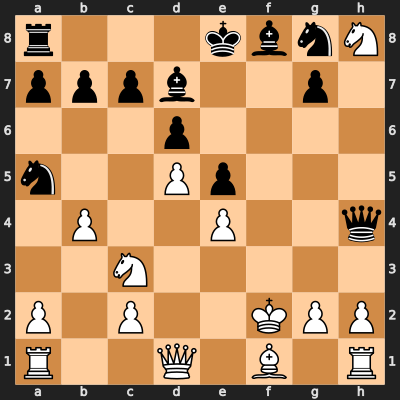

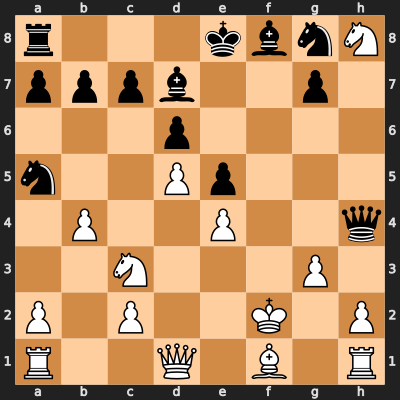

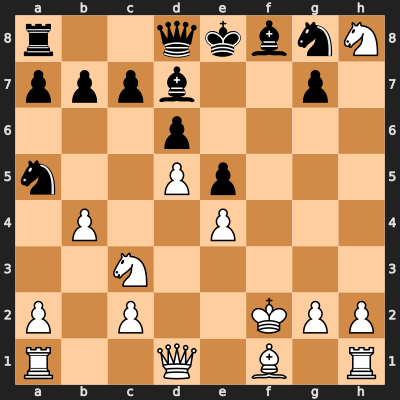

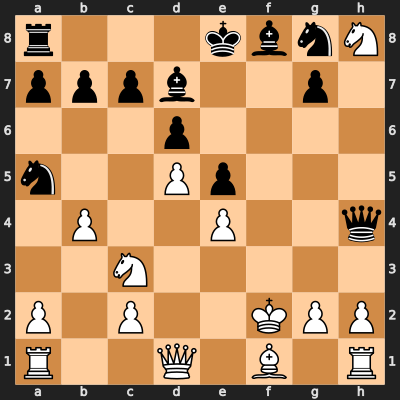

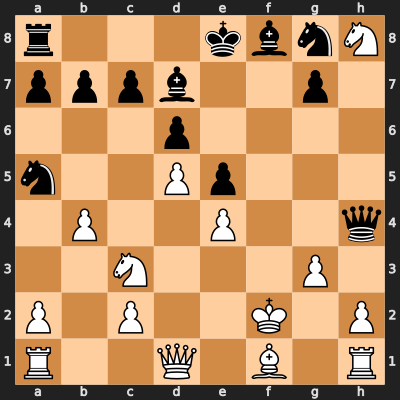

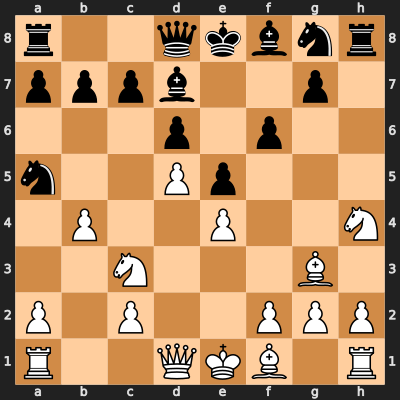

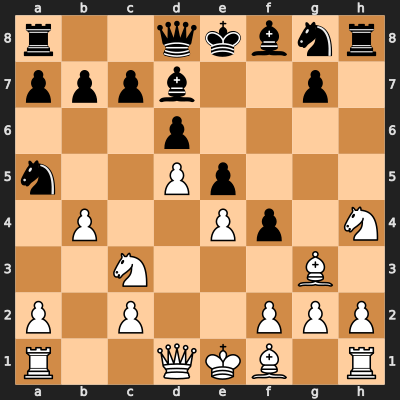

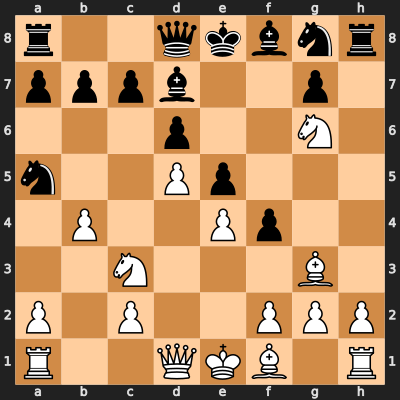

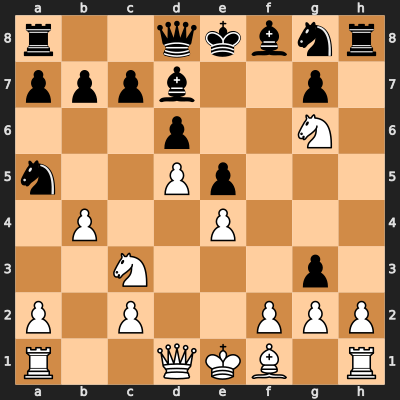

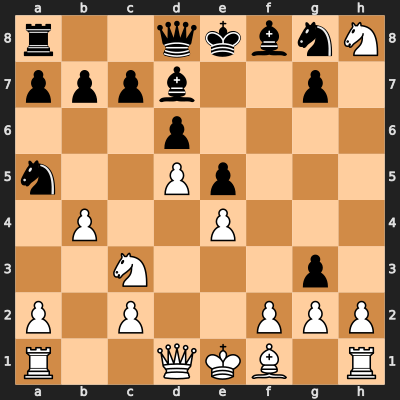

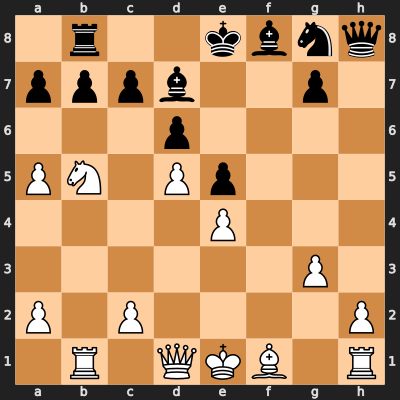

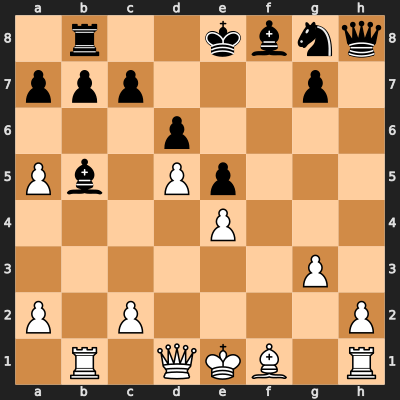

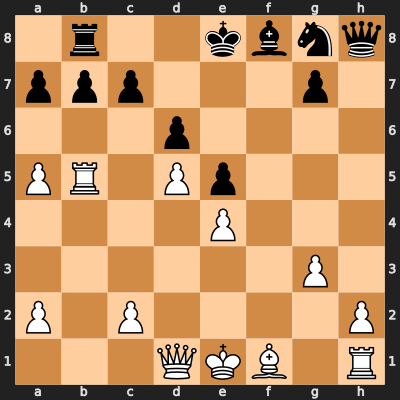

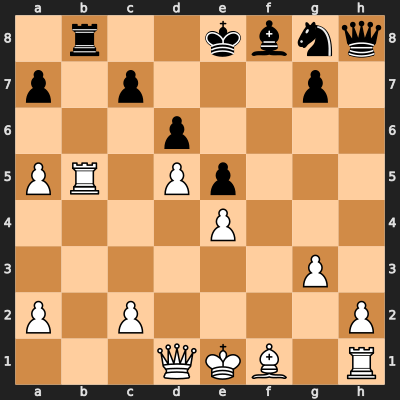

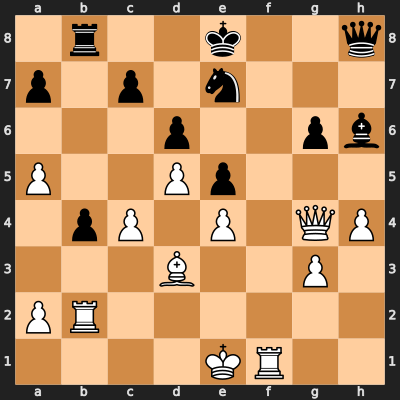

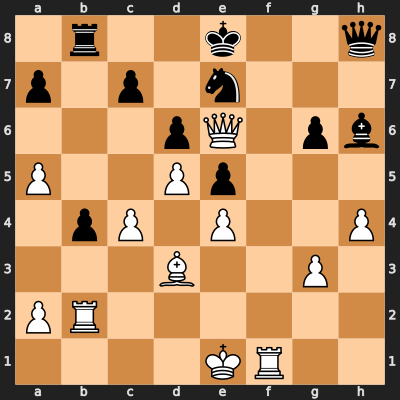

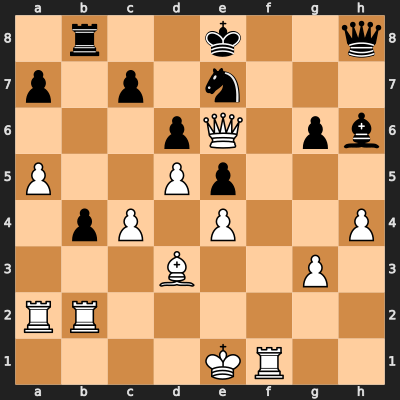

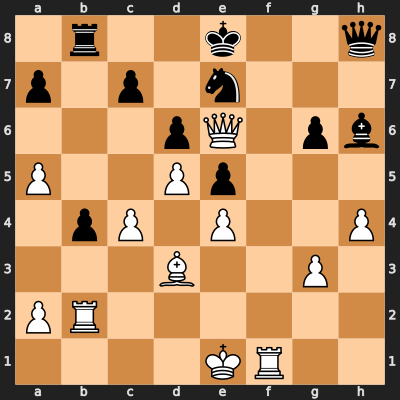

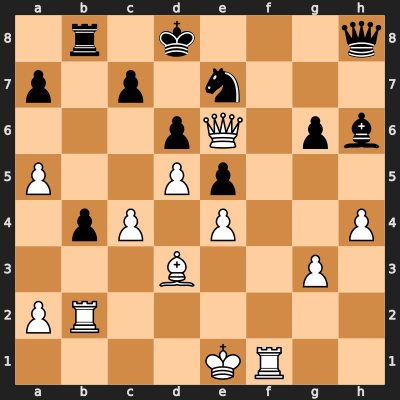

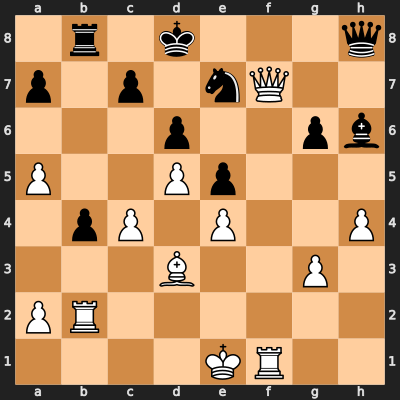

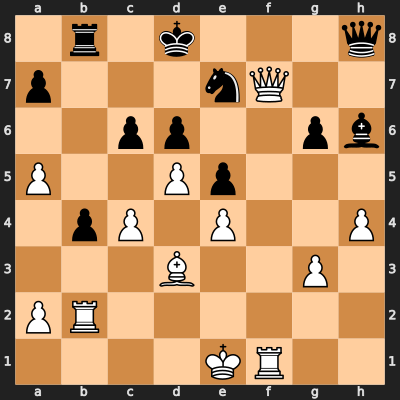

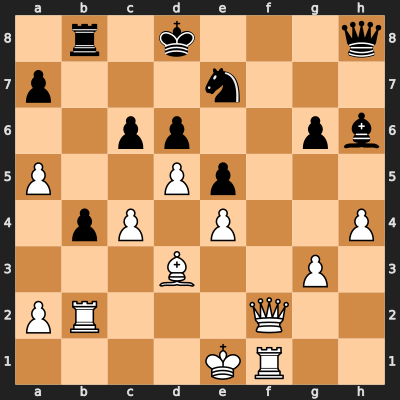

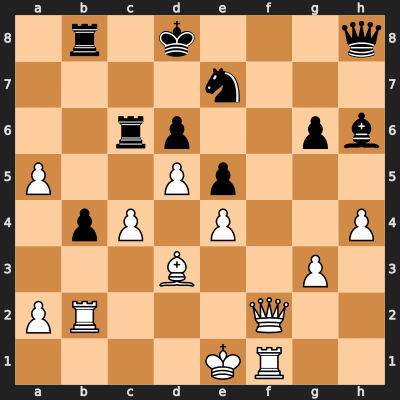

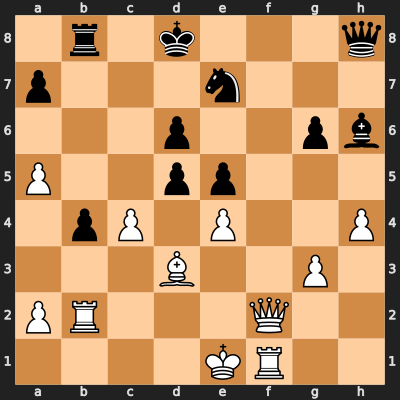

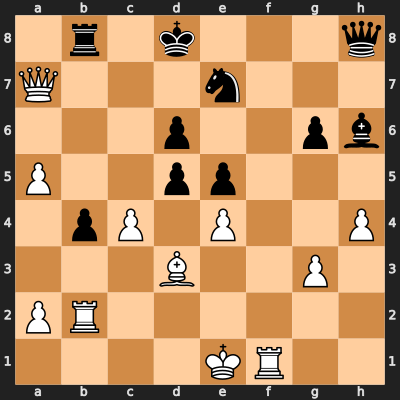

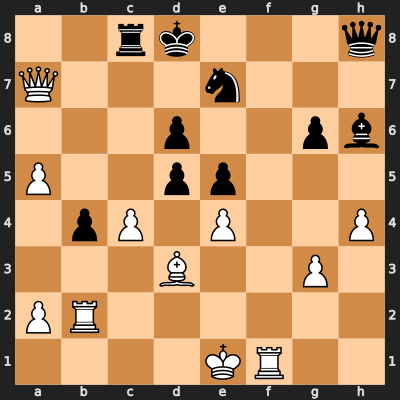

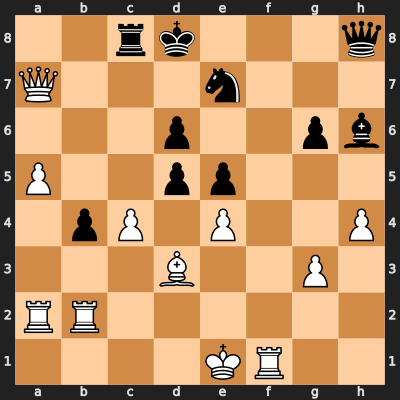

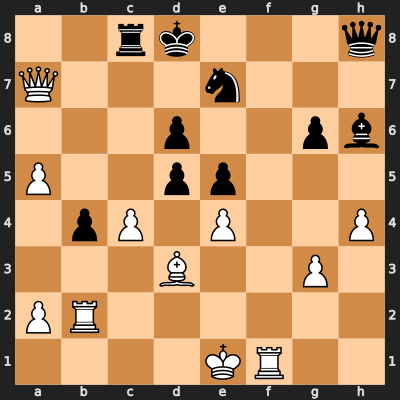

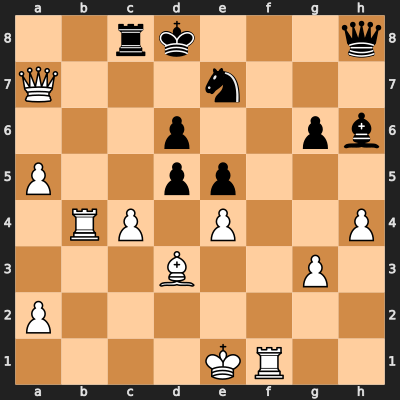

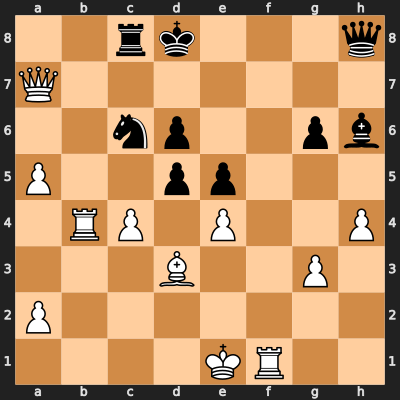

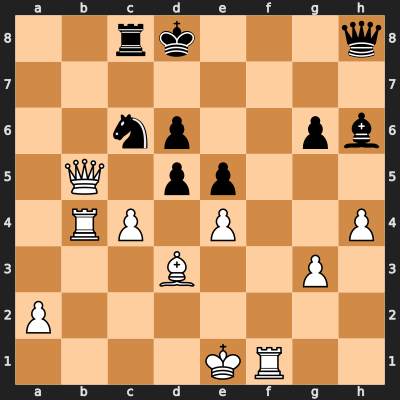

                      row_id  \
0  2_Move_rotate_student.mp4   
1         2_move_student.mp4   
2          4_Move_studet.mp4   
3         6_Move_student.mp4   
4         8_Move_student.mp4   

                                              output  
0                                    1... Qh4+ 2.g3   
1                                    1... Qh4+ 2.g3   
2                                              1. d4  
3                                 1... Bxb5 2.Rxb5    
4  1.Qe6  2. Kd8 3.Qf7 c6 4.Qf2  5. Qxa7 6.Rc8  7...  


In [ ]:
vdo_dir = "/content/drive/MyDrive/cu-chess-detection/test_videos"

df =  video_to_csv(vdo_dir)

In [ ]:
print(df)
df.to_csv("submission_solution.csv", index=False, encoding="utf-8")

                      row_id  \
0  2_Move_rotate_student.mp4   
1         2_move_student.mp4   
2          4_Move_studet.mp4   
3         6_Move_student.mp4   
4         8_Move_student.mp4   

                                              output  
0                                    1... Qh4+ 2.g3   
1                                    1... Qh4+ 2.g3   
2                                              1. d4  
3                                 1... Bxb5 2.Rxb5    
4  1.Qe6  2. Kd8 3.Qf7 c6 4.Qf2  5. Qxa7 6.Rc8  7...  
